# Developing an Ant Colony Optimization algorithm using ROOT

## Introduction

In this document we are going to show how to develop an Ant Colony Optimization algorithm for solving the TSP using the data analysis software package by CERN, ROOT. The interface is in python to keep things simple but the logic is in C++.

In [1]:
from __future__ import division

import ROOT
import igraph

distgraph = [
    [0,5,20,5],
    [5,0,5,2],
    [20,5,0,7],
    [5,2,7,0]
]

from ROOT import std

dg = std.vector('std::vector<double>')()

def vector2d_from_list(lst):
    ret = std.vector('std::vector<double>')()
    for row in distgraph:
        temp = std.vector('double')()
        for col in row:
            temp.push_back(col)
        ret.push_back(temp);
    return(ret)
        

Welcome to ROOTaaS 6.06/00


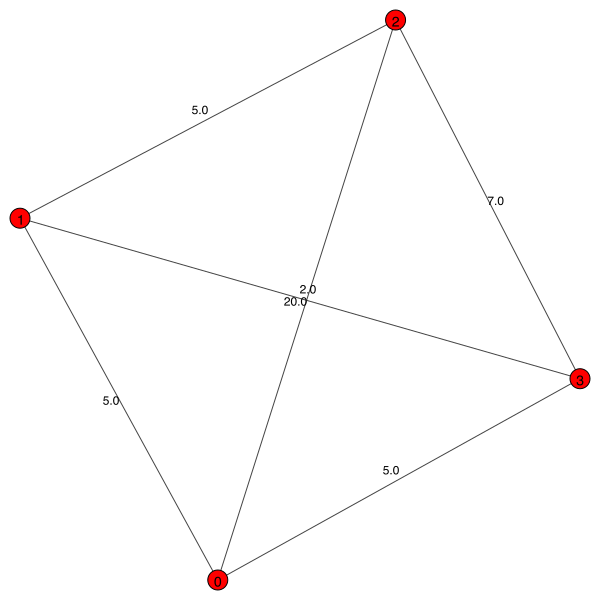

In [63]:
g = igraph.Graph.Weighted_Adjacency(distgraph, mode = igraph.ADJ_MAX, loops = False, attr = "weight")
g.vs['label'] = range(len(distgraph))
igraph.plot(g, labels = True, edge_label=g.es["weight"])

In [10]:
%%cpp
cout << "hello" << endl;

hello


In [11]:

%%cpp -d
void print_vector2d(const std::vector<std::vector<double> >& v)
        {
            for (const auto& row:v){
                for (const auto& col:row) {
                    std::cout << col << " ";
                }
                std::cout << endl;
            }
        }

In [12]:
ROOT.print_vector2d(vector2d_from_list(distgraph))

0 5 20 5 
5 0 5 2 
20 5 0 7 
5 2 7 0 


In [13]:
init_pherom = 1/len(distgraph)

In [14]:
pheromones = [
    [(init_pherom if x!=y else 0.0) for x in range(len(distgraph))] 
              for y in range(len(distgraph))
]

In [15]:
pheromones

[[0.0, 0.25, 0.25, 0.25],
 [0.25, 0.0, 0.25, 0.25],
 [0.25, 0.25, 0.0, 0.25],
 [0.25, 0.25, 0.25, 0.0]]

In [16]:
ROOT.print_vector2d(vector2d_from_list(pheromones))

0 5 20 5 
5 0 5 2 
20 5 0 7 
5 2 7 0 


In [17]:
ROOT.print_vector2d(vector2d_from_list(distgraph))

0 5 20 5 
5 0 5 2 
20 5 0 7 
5 2 7 0 


In [18]:
pheromones


[[0.0, 0.25, 0.25, 0.25],
 [0.25, 0.0, 0.25, 0.25],
 [0.25, 0.25, 0.0, 0.25],
 [0.25, 0.25, 0.25, 0.0]]

Each ant selects the arc to follow with the following probability $$p_{ij}=\frac{\eta_{ij}^\alpha \tau_{ij}^\beta}{\sum\limits_{k}\eta_{ij}^\alpha \tau_{ij}^\beta}$$
Here we define the settings as a list with [$\alpha$, $\beta$, $\rho$, QVAL]

In [19]:

%%cpp -d
#include <vector>

#include <cmath>
#include <random>
#include <cassert>
class Ant {
    int initCity;
    std::vector<std::vector<double> >* pheromones;
    std::vector<std::vector<double> >* dist;
    std::vector<unsigned char> visited{};

public:
    std::vector<double> settings{1.0, 5.0, 0.5, 100};
    double tourLength;
    std::vector<int> builtPath{};

    int getInitCity() const
    {
        return initCity;
    }

    void setInitCity(int initCity)
    {
        Ant::initCity = initCity;
    }

    Ant(int city, std::vector<std::vector<double> >* pherom, std::vector<std::vector<double> >* distgraph)
            :initCity(city), pheromones(pherom), dist(distgraph)
    {
        visited.resize(dist->size());
        visited[city] = 1;
    }

    double prob(int from, int to)
    {
        double nom = (std::pow(1/(*dist)[from][to], settings[0])*std::pow((*pheromones)[from][to], settings[1]));
        double denom = 0.0;
        for (int i = 0; i<visited.size(); ++i) {
            if (visited[i]==0) {
                denom += (std::pow(1/(*dist)[from][i], settings[0])*std::pow((*pheromones)[from][i], settings[1]));
            }
        }
        if (denom>0.00001) {
            return nom/denom;
        }
        else {
            return 1.0;
        }
    }

    double run()
    {
        int visitNum = 0;
        int size = dist->size();
        int curCity = initCity;
        std::random_device rand;
        double tourLen = 0.0;
        visited.clear();
        visited.resize(size);
        visited[curCity] = 1;
        builtPath.clear();
        builtPath.resize(size);
        builtPath[visitNum] = curCity;
        while (visitNum<(size-1)) {

            double probNum;
            double visitProb;
            int index;

            index = curCity;
            do {
                ++index;
                if (index>=size) {
                    index = 0;
                }
                if (visited[index]) {
                    visitProb = 0;
                }
                else {
                    visitProb = prob(curCity, index);
                }
                probNum = static_cast<double>(rand())/rand.max();
            }
            while (probNum>visitProb);
            tourLen += (*dist)[curCity][index];
            curCity = index;
            visited[index] = 1;
            visitNum++;
            builtPath[visitNum] = curCity;
        }
        tourLen += (*dist)[curCity][initCity];
        tourLength = tourLen;
        return tourLen;
    }

};

In [20]:
ROOT.Ant

ROOT.Ant

In [21]:

%%cpp -d
class ACO {
private:
    std::vector<std::vector<double> > dist;
    std::vector<std::vector<double> > pheromones{{}};

    std::vector<int> bestPath{};
public:
    std::vector<double> settings{1.0, 5.0, 0.5, 100};
    int numAnts = -1;
    int maxIter;
    double bestCost;

    const std::vector<int>& getBestPath() const
    {
        return bestPath;
    }

    ACO(std::vector<std::vector<double> > distgraph, int iters = 10, int numAnt = -1)
            :dist(distgraph), numAnts(numAnt), maxIter(iters) { if (numAnt==-1) numAnts = dist.size(); }

    double run()
    {
        double size = dist.size();
        assert(size>0);
        double init_pheromone = 1/size;
        pheromones.resize(size);
        for (int i = 0; i<size; ++i) {
            pheromones[i].resize(size);
        }
        for (int i = 0; i<size; ++i) {
            for (int j = i+1; j<size; ++j) {
                pheromones[i][j] = init_pheromone;
                pheromones[j][i] = init_pheromone;
            }
        }
        bestCost = std::numeric_limits<double>::max();

        for (int i = 0; i<maxIter; ++i) {
            std::vector<Ant> ants(numAnts, {0, &pheromones, &dist});
            int index = 0;
            // Run ants
            for (auto& ant:ants) {
                ant.setInitCity(index);
                ant.settings = settings;
                double curCost = ant.run();
                if (curCost<=bestCost) {
                    bestCost = curCost;
                    bestPath = ant.builtPath;
                }
                if (++index>=size) index = 0;
            }
            // Update pheromones
            for (const auto& ant:ants) {
                for (int i = 0; i<size; ++i) {
                    int from = i;
                    int to = i + 1;
                    if ((i+1) == size) {
                        to = 0;
                    }
                    int antFrom = ant.builtPath[from];
                    int antTo = ant.builtPath[to];
                    pheromones[antFrom][antTo] = pheromones[antFrom][antTo] = (settings[3]/ant.tourLength);
                }
            }

            // Evaporate
            for (int i = 0; i<size; ++i) {
                for (int j = 0; j<size; ++j) {
                    pheromones[i][j] *= settings[2];
                }
            }
        }
        return bestCost;

    }


};

In [22]:
aco = ROOT.ACO(vector2d_from_list(distgraph))

In [23]:
c = aco.run()

In [24]:
aco.bestCost

22.0

In [25]:
p = aco.getBestPath()

In [26]:
print p


<ROOT.vector<int> object at 0x7fb55043d0e0>


In [27]:
p[0]

3

In [28]:
list(p)

[3, 0, 1, 2]

In [97]:
print list(p)

[3, 0, 1, 2]


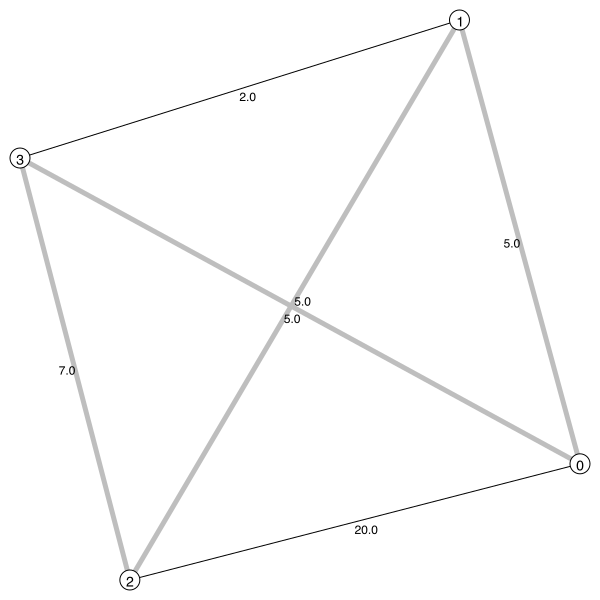

In [145]:
g.es["color"] = "black"
g.es["width"] = 1
g.vs["color"] = "white"
path = list(p)
for i in range(len(path)):
    src = i
    dst = i + 1
    if dst == (len(path)):
        dst = 0
    edge = (path[src], path[dst]) if path[src] < path[dst] else (path[dst], path[src])
    index = g.get_edgelist().index(edge)
    g.es[index]["color"] = "gray"
    g.es[index]["width"] = 5

igraph.plot(g, labels = True, edge_label=g.es["weight"])